## GMM

In [8]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
def initialise_gmm(image,k):
    indices = np.random.choice(image.shape[0], k, replace=False)
    
    means = image[indices] # pixel intensities at those randomly chosen indices 
    covariances = [np.cov(image, rowvar=False) + np.eye(image.shape[1]) * 1e-6] * k #initializes the covariance matrices for each Gaussian component.
    weights = np.ones(k) / k #initializes equal weights for each Gaussian component.
    
    return means, covariances, weights

In [10]:
def gaussian_pdf(image, mean, covariance):
    num_dim = image.shape[1]
    
    sign, logdet = np.linalg.slogdet(covariance)
    if sign <= 0:
        covariance = covariance + np.eye(num_dim) * 1e-6
        sign, logdet = np.linalg.slogdet(covariance)
    
    inv_cov = np.linalg.inv(covariance)
    
    # Calculate Mahalanobis distance (X-μ)ᵀΣ⁻¹(X-μ)
    diff = image - mean
    mahalanobis_dist = np.sum(diff @ inv_cov * diff, axis=1)
    
    # Computing log PDF
    log_pdf = -0.5 * (num_dim * np.log(2 * np.pi) + logdet + mahalanobis_dist)
    return np.exp(log_pdf)

In [11]:
def gmm_em(image, k, iterations, threshold):
    num_samples, num_dim = image.shape
    means, covariances, weights = initialise_gmm(image, k)
    
    log_likelihood = -np.inf
    
    for iteration in tqdm(range(iterations), desc="GMM EM Progress"):
        # E-Step: Compute probabilities of each data point belonging to a gaussian
        prob_data_point = np.zeros((num_samples, k))
        
        for gaussian in range(k):
            prob_data_point[:, gaussian] = weights[gaussian] * gaussian_pdf(image, means[gaussian], covariances[gaussian])
        
        prob_data_point = prob_data_point / prob_data_point.sum(axis=1, keepdims=True)
        
        # M-Step: Update parameters
        Nk = prob_data_point.sum(axis=0)
        
        weights = Nk / num_samples
        
        for j in range(k):
            means[j] = np.sum(prob_data_point[:, j][:, np.newaxis] * image, axis=0) / Nk[j]
        
        for j in range(k):
            diff = image - means[j]
            covariances[j] = (prob_data_point[:, j][:, np.newaxis] * diff).T @ diff / Nk[j]
        
        weighted_pdf = np.zeros((num_samples, k))
        for j in range(k):
            weighted_pdf[:, j] = weights[j] * gaussian_pdf(image, means[j], covariances[j])
        
        # Using log-sum-exp trick for numerical stability
        max_weighted_pdf = np.max(weighted_pdf, axis=1, keepdims=True)
        log_weighted_pdf = np.log(weighted_pdf / max_weighted_pdf + 1e-10) + np.log(max_weighted_pdf + 1e-10)
        curr_log_likelihood = np.sum(np.log(np.sum(np.exp(log_weighted_pdf), axis=1)))
        
        print(f"Iteration: {iteration}, Log-Likelihood: {curr_log_likelihood}")
        
        # Checking for convergence
        if iteration > 0 and abs(curr_log_likelihood - log_likelihood) < threshold:
            break
            
        log_likelihood = curr_log_likelihood
    
    return means, covariances, weights, prob_data_point


In [ ]:
# Segment the original image using GMM parameters and return a segmented image with labels 1 to k for each voxel.
def segment_image(original_image, means, covariances, weights, k):
    segmented_image = np.zeros_like(original_image)
    mask = original_image > 0 # Remove background and create a mask
    nonzero_voxels = original_image[mask].reshape(-1, 1) # Extract non-zero voxels
    
    prob_data_point = np.zeros((nonzero_vo##############3######33####33#####3333xels.shape[0], k)) # probability for each voxel belonging to each Gaussian
    
    for j in range(k):
        prob_data_point[:, j] = weights[j] * gaussian_pdf(nonzero_voxels, means[j], covariances[j])
    
    labels = np.argmax(prob_data_point, axis=1) # Assigning each voxel to the most likely Gaussian component (0-based) for the original image
    
    segmented_flat = np.zeros(original_image.size)
    segmented_flat[mask.flatten()] = labels + 1  # Convert to 1-based labels for visualization
    
    segmented_image = segmented_flat.reshape(original_image.shape) # Reshaping back to original image dimensions
    return segmented_image

In [13]:
def load_nii(filepath):
    img = nib.load(filepath)
    data = img.get_fdata()
    return data

In [14]:
k=3
iterations=20
threshold=1e-6
image_path="OneDrive_1_3-14-2025/sald_031764_img.nii"

In [15]:
original_image = load_nii(image_path)

nonzero_mask = original_image > 0 # Extract non-zero voxels for GMM
image_for_gmm = original_image[nonzero_mask].reshape(-1, 1)
means, covariances, weights, responsibilities = gmm_em(image_for_gmm, k, iterations, threshold)

GMM EM Progress:   5%|▌         | 1/20 [00:00<00:11,  1.60it/s]

Iteration: 0, Log-Likelihood: -9997649.311043164


GMM EM Progress:  10%|█         | 2/20 [00:01<00:11,  1.57it/s]

Iteration: 1, Log-Likelihood: -9981611.146181175


GMM EM Progress:  15%|█▌        | 3/20 [00:01<00:11,  1.53it/s]

Iteration: 2, Log-Likelihood: -9977235.466472806


GMM EM Progress:  20%|██        | 4/20 [00:02<00:10,  1.53it/s]

Iteration: 3, Log-Likelihood: -9974006.899254851


GMM EM Progress:  25%|██▌       | 5/20 [00:03<00:09,  1.53it/s]

Iteration: 4, Log-Likelihood: -9970762.654280491


GMM EM Progress:  30%|███       | 6/20 [00:03<00:09,  1.53it/s]

Iteration: 5, Log-Likelihood: -9967011.099063735


GMM EM Progress:  35%|███▌      | 7/20 [00:04<00:08,  1.53it/s]

Iteration: 6, Log-Likelihood: -9962441.083306761


GMM EM Progress:  40%|████      | 8/20 [00:05<00:07,  1.53it/s]

Iteration: 7, Log-Likelihood: -9956890.73102947


GMM EM Progress:  45%|████▌     | 9/20 [00:05<00:07,  1.54it/s]

Iteration: 8, Log-Likelihood: -9950439.896703646


GMM EM Progress:  50%|█████     | 10/20 [00:06<00:06,  1.53it/s]

Iteration: 9, Log-Likelihood: -9943475.662972357


GMM EM Progress:  55%|█████▌    | 11/20 [00:07<00:05,  1.53it/s]

Iteration: 10, Log-Likelihood: -9936546.955023387


GMM EM Progress:  60%|██████    | 12/20 [00:07<00:05,  1.53it/s]

Iteration: 11, Log-Likelihood: -9930023.029402087


GMM EM Progress:  65%|██████▌   | 13/20 [00:08<00:04,  1.53it/s]

Iteration: 12, Log-Likelihood: -9923899.889038851


GMM EM Progress:  70%|███████   | 14/20 [00:09<00:03,  1.54it/s]

Iteration: 13, Log-Likelihood: -9917999.608211588


GMM EM Progress:  75%|███████▌  | 15/20 [00:09<00:03,  1.54it/s]

Iteration: 14, Log-Likelihood: -9912193.100471301


GMM EM Progress:  80%|████████  | 16/20 [00:10<00:02,  1.54it/s]

Iteration: 15, Log-Likelihood: -9906492.802294882


GMM EM Progress:  85%|████████▌ | 17/20 [00:11<00:01,  1.53it/s]

Iteration: 16, Log-Likelihood: -9901020.274256624


GMM EM Progress:  90%|█████████ | 18/20 [00:11<00:01,  1.54it/s]

Iteration: 17, Log-Likelihood: -9895894.894917466


GMM EM Progress:  95%|█████████▌| 19/20 [00:12<00:00,  1.54it/s]

Iteration: 18, Log-Likelihood: -9891125.16053585


GMM EM Progress: 100%|██████████| 20/20 [00:13<00:00,  1.54it/s]

Iteration: 19, Log-Likelihood: -9886580.17193887


In [16]:
def calculate_accuracy(prob_masks,k,original_image,segmented_image):
    ground_truth = np.zeros_like(original_image)
    probabilities = np.zeros((original_image.shape) + (k + 1,))

    for i, mask in enumerate(prob_masks): # Loading each tissue's(k) probability into the array
        probabilities[..., i+1] = mask
        
    ground_truth = np.argmax(probabilities, axis=-1)

    overlap_matrix = np.zeros((k+1, k+1))

    for gmm_label in range(1, k+1): 
        for tissue_label in range(1, k+1):
            overlap = np.sum((segmented_image == gmm_label) & (ground_truth == tissue_label))
            overlap_matrix[gmm_label, tissue_label] = overlap

    # Determining the best mapping
    optimal_mapping = {}
    optimal_mapping[0] = 0  # Means that background maps to background

    # For each GMM label, finding the tissue with highest overlap
    for gmm_label in range(1, k+1):
        best_tissue = np.argmax(overlap_matrix[gmm_label, 1:]) + 1
        optimal_mapping[gmm_label] = best_tissue

    print(f"Optimal tissue mapping: {optimal_mapping}")

    # Applying optimal mapping
    remapped_segmentation = np.zeros_like(segmented_image)
    for gmm_label, tissue_label in optimal_mapping.items():
        remapped_segmentation[segmented_image == gmm_label] = tissue_label

    accuracy = np.mean(remapped_segmentation == ground_truth)
    print(f"Overall accuracy: {accuracy*100:.4f}")
    return remapped_segmentation,ground_truth

In [17]:
prob_mask_paths = [
    "OneDrive_1_3-14-2025/sald_031764_probmask_csf.nii",  # CSF
    "OneDrive_1_3-14-2025/sald_031764_probmask_graymatter.nii",   # Gray Matter
    "OneDrive_1_3-14-2025/sald_031764_probmask_whitematter.nii"    # White Matter
]
prob_masks = [load_nii(path) for path in prob_mask_paths]

for i, mask in enumerate(prob_masks):
    print(f"Probability mask shape: {mask.shape}")

segmented_image = segment_image(original_image, means, covariances, weights, k)
remapped_segmentation,ground_truth=calculate_accuracy(prob_masks,k,original_image,segmented_image)

Probability mask shape: (182, 218, 182)
Probability mask shape: (182, 218, 182)
Probability mask shape: (182, 218, 182)
Optimal tissue mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Overall accuracy: 93.7270


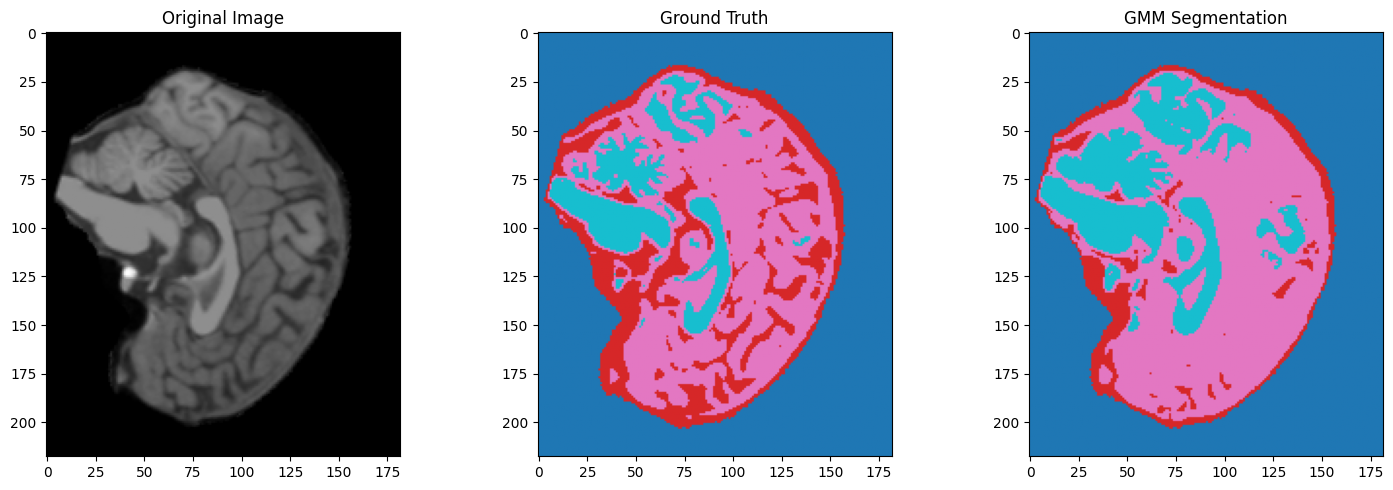

In [18]:
import matplotlib.pyplot as plt

middle_slice = original_image.shape[0] // 2

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Original Image")
plt.imshow(original_image[middle_slice], cmap='gray')

plt.subplot(132)
plt.title("Ground Truth")
plt.imshow(ground_truth[middle_slice], cmap='tab10', vmin=0, vmax=k)

plt.subplot(133)
plt.title("GMM Segmentation")
plt.imshow(remapped_segmentation[middle_slice], cmap='tab10', vmin=0, vmax=k)

plt.tight_layout()
plt.savefig("segmentation_results.png")

#### GMM Segmentation vs Ground Truth:

Ground Truth : This shows the ground truth segmentation, which is the expert-labeled or "correct" segmentation of the brain tissues. It's color-coded with:
- Blue: Background/non-brain tissue
- Red: White matter
- Pink: Gray matter 
- Cyan: CSF (Cerebrospinal fluid)

GMM Segmentation:
You can see that the major structures are correctly identified - the outer red layer (white matter), the middle pink (gray matter), and the inner cyan regions (CSF).

In [19]:
from scipy.stats import norm

def visualize_intensity_distributions(original_image, segmented_image, means, covariances, weights):
    tissue_names = ['CSF', 'GM', 'WM']
    
    means = np.array([m[0] for m in means])
    stds = np.array([np.sqrt(c[0][0]) for c in covariances])
    
    sort_idx = np.argsort(means)
    means = means[sort_idx]
    stds = stds[sort_idx]
    weights = weights[sort_idx]
    
    mask = original_image > 0
    intensities = original_image[mask]

    labels = segmented_image[mask]
    
    colors = ['blue', 'green', 'red']
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.hist(intensities, bins=100, alpha=0.5, density=True, label='All voxels')
    
    x = np.linspace(np.min(intensities), np.max(intensities), 1000)
    gmm_pdf = np.zeros_like(x)
    
    colors = ['blue', 'green', 'red']
    for i, (mu, sigma, w) in enumerate(zip(means, stds, weights)):
        component_pdf = w * norm.pdf(x, mu, sigma)
        gmm_pdf += component_pdf
        plt.plot(x, component_pdf, label=f'{tissue_names[i]} (μ={mu:.1f}, σ={sigma:.1f})', color=colors[i], linewidth=2)
    
    plt.plot(x, gmm_pdf, 'k--', label='Combined GMM', linewidth=2)
    plt.title('Overall Intensity Distribution and GMM Components')
    plt.xlabel('Intensity')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    plt.figure(figsize=(12, 8))
    
    for i in range(1, len(tissue_names) + 1):
        label_intensities = intensities[labels == i]
        if len(label_intensities) > 0:
            hist, bins = np.histogram(label_intensities, bins=100, density=True)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            plt.plot(bin_centers, hist, '-', linewidth=2, 
                     label=f'{tissue_names[i-1]} (n={len(label_intensities)})', 
                     color=colors[i-1])
    
    plt.title('Intensity vs Frequency for Each Tissue Class')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add vertical lines for the means
    for i, mu in enumerate(means):
        plt.axvline(x=mu, color=colors[i], linestyle='--', alpha=0.7,
                   label=f'{tissue_names[i]} mean ({mu:.1f})')
    
    plt.tight_layout()
    plt.savefig('intensity_vs_frequency.png', dpi=300)
    plt.show()
    
    return

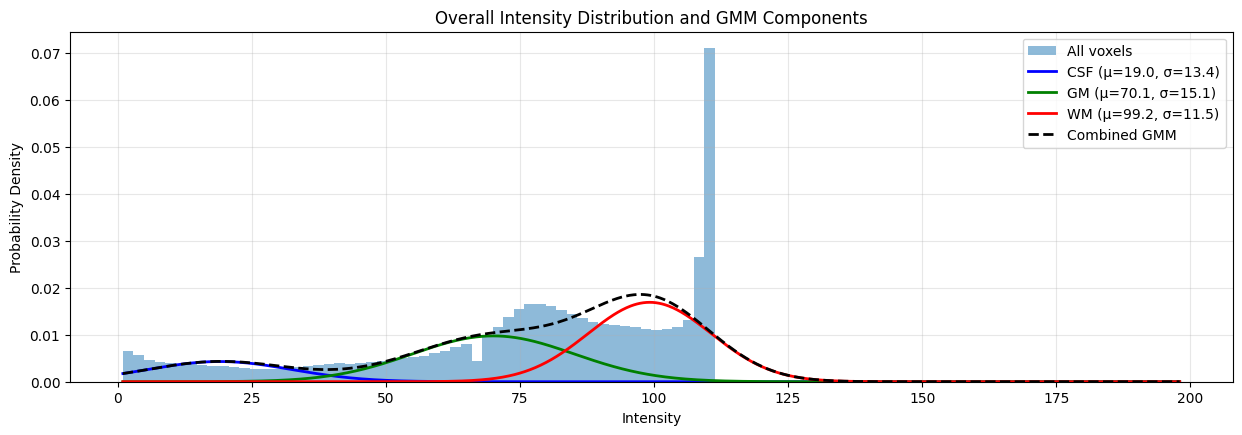

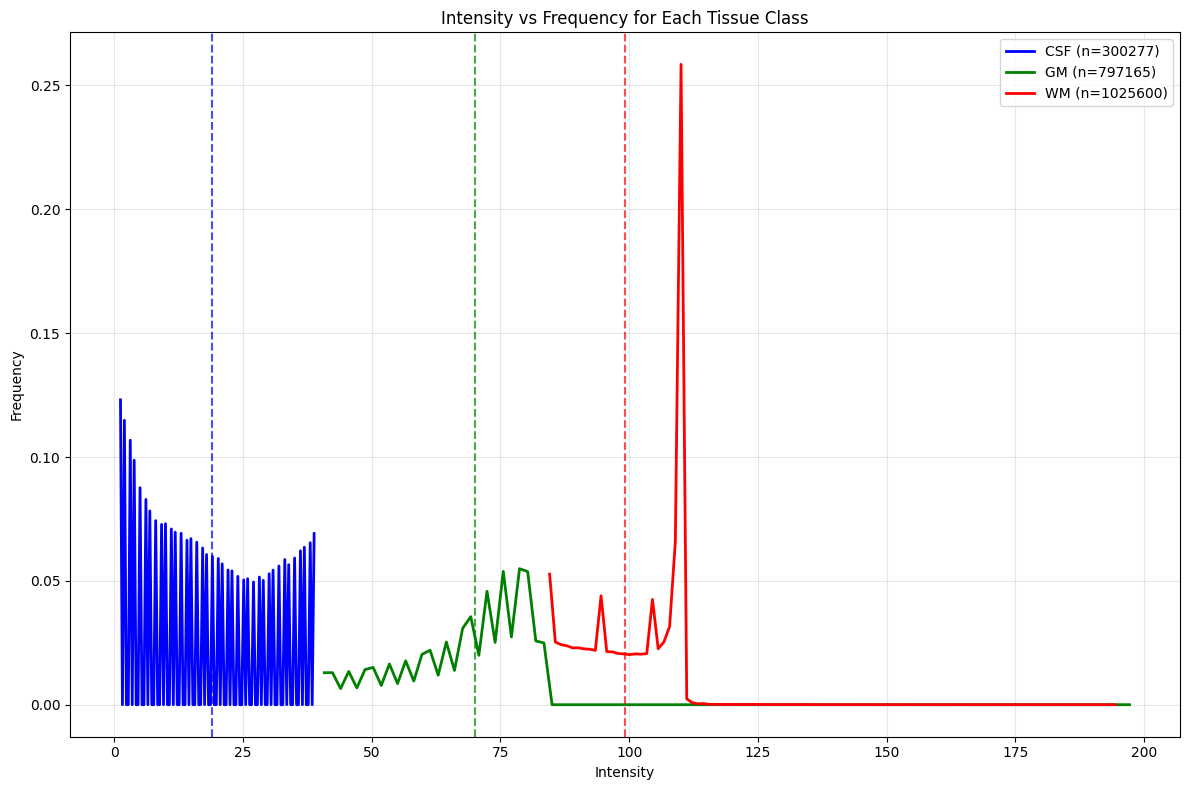

In [20]:
visualize_intensity_distributions(original_image, segmented_image, means, covariances, weights)

#### Frequency vs Intensity Graph:

The histogram shows the frequency of different intensity values for each tissue class: CSF (blue), GM (green), and WM (red).
The peaks in intensity distribution indicate where most pixels for each class are located.
The overlap between different intensity regions suggests potential areas of misclassification.

1. Looking at these can you explain where is the highest misclassification and why?

- The highest misclassification is likely in the GM-WM boundary due to overlapping intensity distributions. The CSF region may have better classification but could still suffer from some misclassified pixels in low-intensity regions.

- CSF (blue) has a distinct intensity peak, so it is well-separated. However, some misclassification can occur where CSF pixels have intensities close to GM, especially in areas where image noise or partial volume effects exist.

Why does this happen?

- GMM relies on intensity distributions, and if two tissues have overlapping intensities, it struggles to distinguish them.

- At the boundaries, a single voxel may contain a mix of tissues, making classification ambiguous